In [1]:
import numpy as np
import pymc as pm
import pandas as pd
from pytensor import tensor as pt
from matplotlib import pyplot as plt
from sunode.solver import Solver
import sunode
import sunode.wrappers.as_pytensor
import arviz as az

pm.__version__

'5.10.0'

Test with Lotka - Volterra model.  Based on the example from the
https://github.com/pymc-devs/sunode

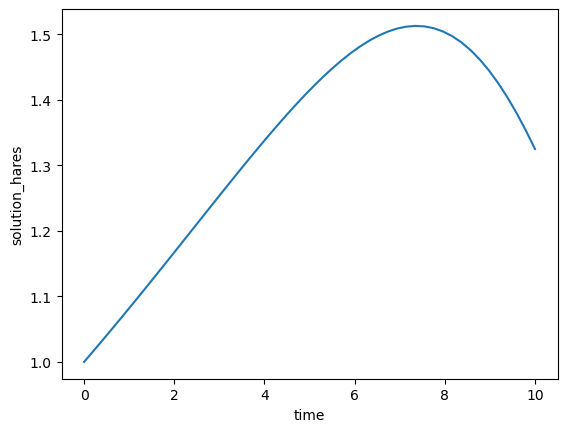

In [2]:
def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'hares': p.alpha * y.hares - p.beta * y.lynx * y.hares,
        'lynx': p.delta * y.hares * y.lynx - p.gamma * y.lynx,
    }


from sunode.symode import SympyProblem
problem = SympyProblem(
    params={
        # We need to specify the shape of each parameter.
        # Any empty tuple corresponds to a scalar value.
        'alpha': (),
        'beta': (),
        'gamma': (),
        'delta': (),
    },
    states={
        # The same for all state variables
        'hares': (),
        'lynx': (),
    },
    rhs_sympy=lotka_volterra,
    derivative_params=[
        # We need to specify with respect to which variables
        # gradients should be computed.
        ('alpha',),
        ('beta',),
    ],
)

# The solver generates uses numba and sympy to generate optimized C functions
# for the right-hand-side and if necessary for the jacobian, adoint and
# quadrature functions for gradients.
from sunode.solver import Solver
solver = Solver(problem, sens_mode=None, solver='BDF')


import numpy as np
tvals = np.linspace(0, 10)
# We can use numpy structured arrays as input, so that we don't need
# to think about how the different variables are stored in the array.
# This does not introduce any runtime overhead during solving.
y0 = np.zeros((), dtype=problem.state_dtype)
y0['hares'] = 1
y0['lynx'] = 0.1

# We can also specify the parameters by name:
solver.set_params_dict({
    'alpha': 0.1,
    'beta': 0.2,
    'gamma': 0.3,
    'delta': 0.4,
})

output = solver.make_output_buffers(tvals)
solver.solve(t0=0, tvals=tvals, y0=y0, y_out=output)

# We can convert the solution to an xarray Dataset
solver.as_xarray(tvals, output).solution_hares.plot()


Ok now try to use PYMC , again following the same documentation

In [3]:
# read in the data
data = pd.read_csv('ode_data.csv')
data.head()

,hare,lynx,times
0,30.486976,3.834610,0
1,44.160586,4.837056,1
2,69.656387,8.450679,2
3,69.065203,25.240121,3
4,39.001649,43.107375,4


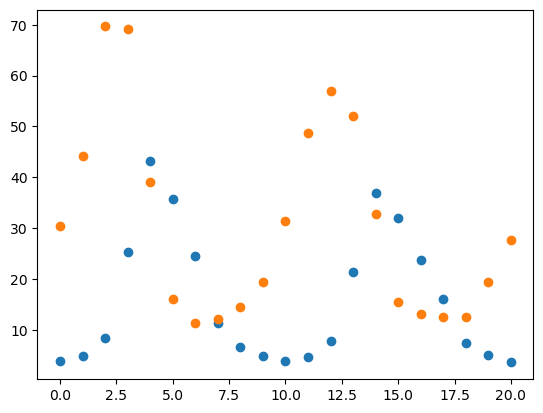

In [4]:
# plot the data
plt.plot(data.times, data.lynx, 'o')
plt.plot(data.times, data.hare, 'o')

In [5]:
# This function might not really be needed:
def log_if_pos(x):
    return pt.switch(x>0,pt.log(x),pt.zeros_like(x))

with pm.Model() as model:
    hares_start = pm.TruncatedNormal('hares_start',mu = 10, sigma=50, lower = 0.1)
    lynx_start = pm.TruncatedNormal('lynx_start', mu = 10, sigma=50, lower  = 0.1)
     
    alpha = pm.TruncatedNormal('alpha', mu=0.5, sigma = 1, lower = 0, upper=2)
    beta = pm.TruncatedNormal('beta', mu=0.5, sigma = 1, lower = 0, upper=2)
    gamma = pm.TruncatedNormal('gamma', mu=0.5, sigma = 1, lower = 0, upper=2)
    delta = pm.TruncatedNormal('delta', mu=0.5, sigma = 1, lower = 0, upper=2)
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
        # The initial conditions of the ode. Each variable
        # needs to specify a PyTensor or numpy variable and a shape.
        # This dict can be nested.
            'hares': (hares_start, ()),
            'lynx': (lynx_start, ()),
        },
        params={
        # Each parameter of the ode. sunode will only compute derivatives
        # with respect to PyTensor variables. The shape needs to be specified
        # as well. It it infered automatically for numpy variables.
        # This dict can be nested.
            'alpha': (alpha, ()),
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'delta': (delta, ()),
            'extra': np.zeros(1),
        },
        # A functions that computes the right-hand-side of the ode using
        # sympy variables.
        rhs=lotka_volterra,
        # The time points where we want to access the solution
        tvals=data.times,
        t0=data.times[0]
    )
    
    # We can access the individual variables of the solution using the
    # variable names.
    pm.Deterministic('hares_mu', y_hat['hares'])
    pm.Deterministic('lynx_mu', y_hat['lynx'])
    
    sd = pm.Exponential('sd',10) 
    # multiplicate error.  This can propduce nans if y goes negative, but it doesnt cause any problems
    # Nevertheless to match the julia version I use 'log_if_pos' .
    pm.LogNormal('hares', mu=log_if_pos(y_hat['hares']), sigma=sd, observed=data.hare)
    pm.LogNormal('lynx', mu=log_if_pos(y_hat['lynx']), sigma=sd, observed=data.lynx)

In [7]:
with model:
    idata = pm.sample(tune=1000, draws=1000, chains =4,cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [hares_start, lynx_start, alpha, beta, gamma, delta, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 581 seconds.


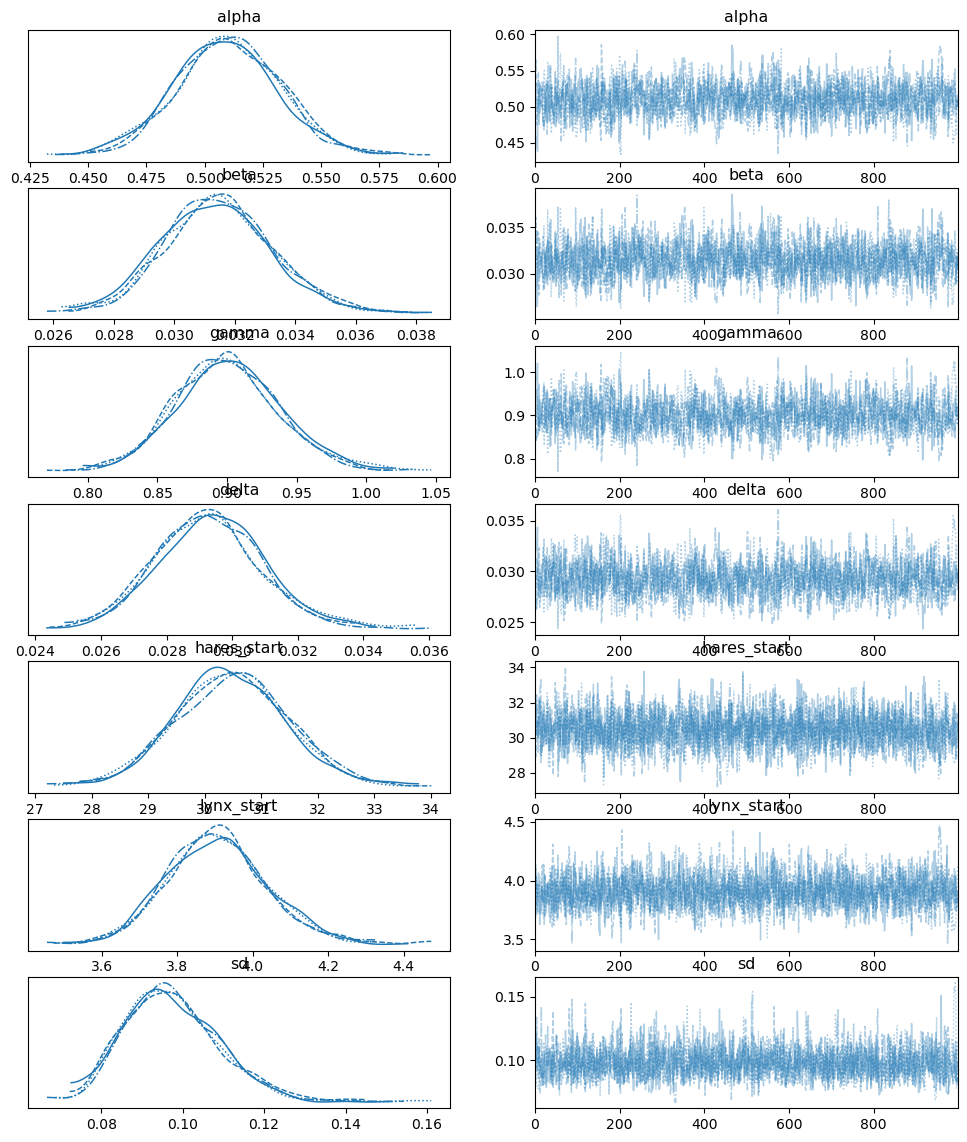

In [8]:
az.plot_trace(idata, var_names=['alpha', 'beta', 'gamma', 'delta', 'hares_start', 'lynx_start', 'sd']);

In [9]:
# list the variables in idata
az.summary(idata, var_names=['alpha', 'beta', 'gamma', 'delta', 'hares_start', 'lynx_start', 'sd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.510,0.022,0.468,0.551,0.001,0.000,1263.0,1392.0,1.0
beta,0.031,0.002,0.028,0.035,0.000,0.000,1389.0,1549.0,1.0
gamma,0.900,0.037,0.834,0.975,0.001,0.001,1232.0,1585.0,1.0
delta,0.029,0.002,0.026,0.032,0.000,0.000,1276.0,1511.0,1.0
hares_start,30.467,0.981,28.676,32.346,0.019,0.014,2584.0,2037.0,1.0
lynx_start,3.906,0.133,3.670,4.164,0.003,0.002,2036.0,2110.0,1.0
sd,0.098,0.012,0.076,0.119,0.000,0.000,1881.0,2048.0,1.0


## Attempt to use PyMC ODE module (even though not reocmmended!)
This was based on [ODE Lotka Volterra Multiple Ways](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html)

In [12]:
from pymc.ode import DifferentialEquation
def rhs_pymcode(y, t, p):
    dH_dt = p[0] * y[0] - p[1] * y[0] * y[1]
    dL_dt = -p[2] * y[1] + p[3] * y[0] * y[1]
    return [dH_dt, dL_dt]


ode_model = DifferentialEquation(
    func=rhs_pymcode, times=data.times, n_states=2, n_theta=4, t0=data.times[0]
)

In [29]:
data_obs = np.array([data.hare,data.lynx]).T

In [30]:
with pm.Model() as model2:
    hares_start = pm.TruncatedNormal('hares_start',mu = 10, sigma=50, lower = 0.1)
    lynx_start = pm.TruncatedNormal('lynx_start', mu = 10, sigma=50, lower  = 0.1)
     
    alpha = pm.TruncatedNormal('alpha', mu=0.5, sigma = 1, lower = 0, upper=2)
    beta = pm.TruncatedNormal('beta', mu=0.5, sigma = 1, lower = 0, upper=2)
    gamma = pm.TruncatedNormal('gamma', mu=0.5, sigma = 1, lower = 0, upper=2)
    delta = pm.TruncatedNormal('delta', mu=0.5, sigma = 1, lower = 0, upper=2)
    
    # solution
    ode_solution = ode_model(y0=[hares_start, lynx_start], theta=[alpha, beta, gamma, delta])
     
    
    # We can access the individual variables of the solution  
    pm.Deterministic('hares_mu', ode_solution[:,0])
    pm.Deterministic('lynx_mu', ode_solution[:,1])
    
    sd = pm.Exponential('sd',10) 
    
    pm.LogNormal('Y', mu=pm.math.log(ode_solution), sigma=sd, observed=data_obs)
     

In [31]:
with model2:
    idata = pm.sample(tune=1000, draws=1000, chains =2,cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hares_start, lynx_start, alpha, beta, gamma, delta, sd]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2927 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


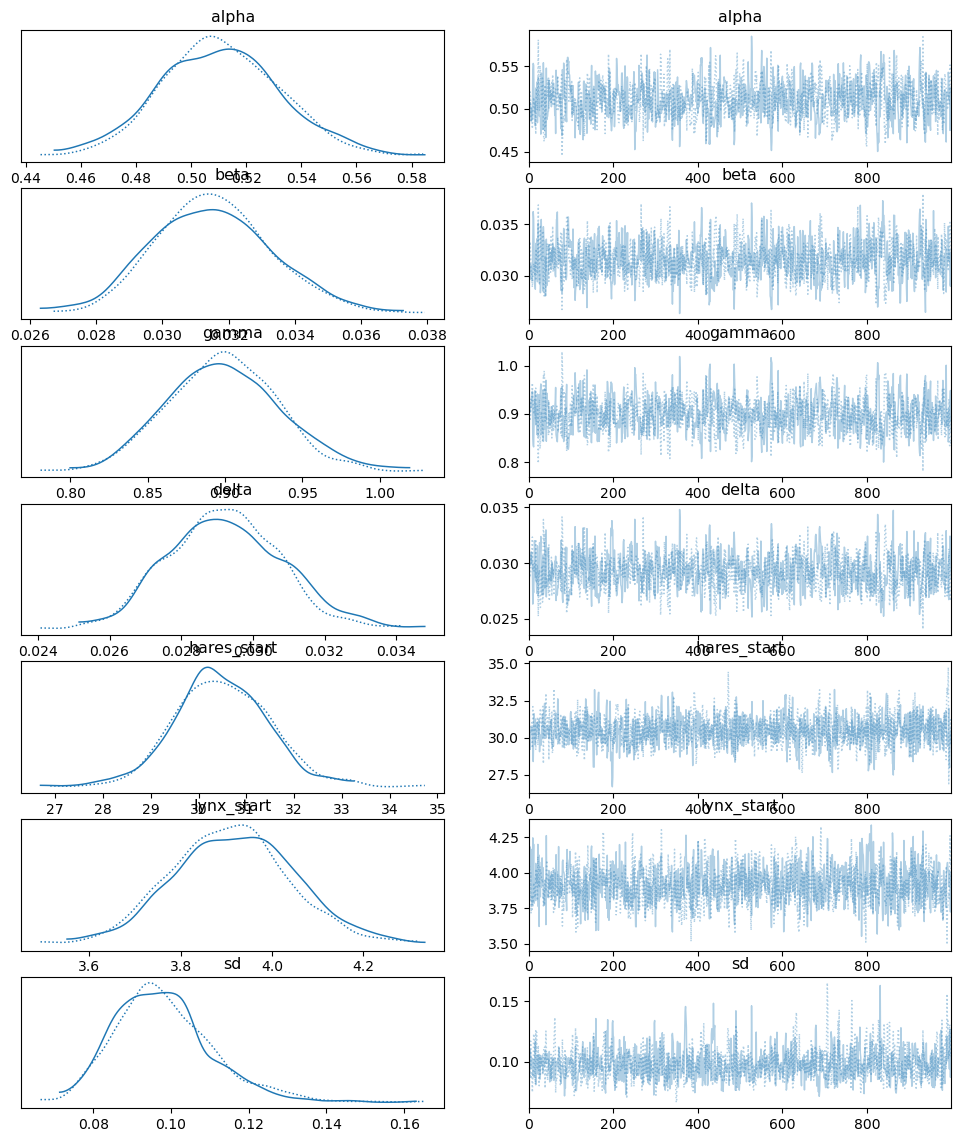

In [32]:
az.plot_trace(idata, var_names=['alpha', 'beta', 'gamma', 'delta', 'hares_start', 'lynx_start', 'sd']);

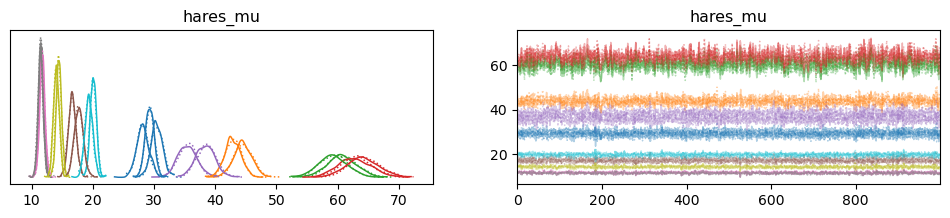

In [33]:
az.plot_trace(idata, var_names=['hares_mu']);